# **Connect to Google Drive**

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpxyilksgo/pubring.gpg' created
gpg: /tmp/tmpxyilksgo/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# **Check Fashion Mnist Data file**

In [4]:
ls drive/CI-CA1/fashionmnist

fashion-mnist_test.csv   t10k-images-idx3-ubyte   train-labels-idx1-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte
fashion-model/           train-images-idx3-ubyte


# **Check GPU connection**

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14481321747383203902, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11288962663
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13559186019566928678
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# **Import Libraries**

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Average, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Input


Using TensorFlow backend.


# **Read data from CSV**

In [0]:
data_train = pd.read_csv('drive/CI-CA1/fashionmnist/fashion-mnist_train.csv')
data_test = pd.read_csv('drive/CI-CA1/fashionmnist/fashion-mnist_test.csv')

# **Preprocess data**

In [0]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255
batch_size = 256
num_classes = 10
epochs = 50
#input image dimensions
img_rows, img_cols = 28, 28

# **Define Compile and Train Function**

In [0]:
def compile_and_train(model, num_epochs): 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    history = model.fit(x=X_train,y= y_train,batch_size=batch_size, epochs=num_epochs,verbose=1,validation_data=(X_val, y_val))
    return history

# **Define Accuracy function**

In [0]:
def evaluate_accuracy(model):
    score = model.evaluate(X_test, y_test, verbose=0)    
    return score[1]

# **Define MLPC model**

In [0]:
model_input = Input(shape=input_shape)
def mlpc(model_input):  
    x=Dense(128, activation='relu')(model_input)
    x=Flatten()(x)
    x=Dense(128, activation='relu')(x)
    x=Dropout(0.3)(x)
    x=Dense(num_classes, activation='softmax')(x)   
    model = Model(model_input, x, name='mplc')
    return model

# **Define CNN model**

In [0]:
def cnn(model_input):
    x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding="same",
        kernel_initializer='he_normal')(model_input)
    x=Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation='relu')(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Dropout(0.5)(x)
    x=Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation='relu')(x)
    x=Conv2D(filters=256, kernel_size=(3, 3), padding="valid", activation='relu')(x)
    x=MaxPooling2D(pool_size=(3, 3))(x)
    x=Dropout(0.5)(x)
    x=Flatten()(x)
    x=Dense(256)(x)
    x=LeakyReLU()(x)
    x=Dropout(0.5)(x)
    x=Dense(256)(x)
    x=LeakyReLU()(x)
    x=Dense(num_classes, activation='softmax')(x)     
    model = Model(model_input, x, name='cnn')
    return model

# **Instantiate MLPC model and train**

In [13]:
mlpc = mlpc(model_input)
history_mlpc=compile_and_train(mlpc, num_epochs=50)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 12s 242us/step - loss: 0.6505 - acc: 0.7700 - val_loss: 0.4277 - val_acc: 0.8452
Epoch 2/50
48000/48000 [==============================] - 11s 228us/step - loss: 0.4522 - acc: 0.8370 - val_loss: 0.4164 - val_acc: 0.8508
Epoch 3/50
11776/48000 [======>.......................] - ETA: 7s - loss: 0.4230 - acc: 0.8461

48000/48000 [==============================] - 11s 230us/step - loss: 0.4311 - acc: 0.8430 - val_loss: 0.3983 - val_acc: 0.8507
Epoch 4/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.4060 - acc: 0.8524 - val_loss: 0.3758 - val_acc: 0.8641
Epoch 5/50
32768/48000 [===================>..........] - ETA: 3s - loss: 0.3977 - acc: 0.8536

48000/48000 [==============================] - 11s 231us/step - loss: 0.3959 - acc: 0.8548 - val_loss: 0.3646 - val_acc: 0.8693
Epoch 6/50
48000/48000 [==============================] - 11s 231us/step - loss: 0.3858 - acc: 0.8581 - val_loss: 0.3654 - val_acc: 0.8638
Epoch 7/50
37632/48000 [======================>.......] - ETA: 2s - loss: 0.3728 - acc: 0.8638

48000/48000 [==============================] - 11s 230us/step - loss: 0.3737 - acc: 0.8633 - val_loss: 0.3688 - val_acc: 0.8692
Epoch 8/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.3672 - acc: 0.8655 - val_loss: 0.3559 - val_acc: 0.8685
Epoch 9/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3592 - acc: 0.8662

48000/48000 [==============================] - 11s 229us/step - loss: 0.3572 - acc: 0.8678 - val_loss: 0.3512 - val_acc: 0.8706
Epoch 10/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.3448 - acc: 0.8749 - val_loss: 0.3439 - val_acc: 0.8740
Epoch 11/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3431 - acc: 0.8748

48000/48000 [==============================] - 11s 229us/step - loss: 0.3411 - acc: 0.8747 - val_loss: 0.3456 - val_acc: 0.8728
Epoch 12/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.3385 - acc: 0.8728 - val_loss: 0.3605 - val_acc: 0.8708
Epoch 13/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3343 - acc: 0.8751

48000/48000 [==============================] - 11s 229us/step - loss: 0.3336 - acc: 0.8748 - val_loss: 0.3422 - val_acc: 0.8775
Epoch 14/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.3263 - acc: 0.8790 - val_loss: 0.3384 - val_acc: 0.8761
Epoch 15/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3220 - acc: 0.8785

48000/48000 [==============================] - 11s 229us/step - loss: 0.3201 - acc: 0.8798 - val_loss: 0.3334 - val_acc: 0.8796
Epoch 16/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.3115 - acc: 0.8836 - val_loss: 0.3395 - val_acc: 0.8764
Epoch 17/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3165 - acc: 0.8814

48000/48000 [==============================] - 11s 230us/step - loss: 0.3166 - acc: 0.8814 - val_loss: 0.3474 - val_acc: 0.8705
Epoch 18/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.3098 - acc: 0.8846 - val_loss: 0.3397 - val_acc: 0.8780
Epoch 19/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.3088 - acc: 0.8860

48000/48000 [==============================] - 11s 229us/step - loss: 0.3058 - acc: 0.8873 - val_loss: 0.3275 - val_acc: 0.8828
Epoch 20/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.2991 - acc: 0.8883 - val_loss: 0.3411 - val_acc: 0.8796
Epoch 21/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2958 - acc: 0.8888

48000/48000 [==============================] - 11s 232us/step - loss: 0.2963 - acc: 0.8885 - val_loss: 0.3342 - val_acc: 0.8787
Epoch 22/50
48000/48000 [==============================] - 11s 231us/step - loss: 0.3001 - acc: 0.8870 - val_loss: 0.3290 - val_acc: 0.8857
Epoch 23/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2854 - acc: 0.8937

48000/48000 [==============================] - 11s 231us/step - loss: 0.2884 - acc: 0.8925 - val_loss: 0.3402 - val_acc: 0.8799
Epoch 24/50
48000/48000 [==============================] - 11s 231us/step - loss: 0.2840 - acc: 0.8944 - val_loss: 0.3332 - val_acc: 0.8802
Epoch 25/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2816 - acc: 0.8943

48000/48000 [==============================] - 11s 229us/step - loss: 0.2807 - acc: 0.8946 - val_loss: 0.3254 - val_acc: 0.8865
Epoch 26/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.2777 - acc: 0.8961 - val_loss: 0.3288 - val_acc: 0.8797
Epoch 27/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2739 - acc: 0.8960

48000/48000 [==============================] - 11s 230us/step - loss: 0.2783 - acc: 0.8942 - val_loss: 0.3268 - val_acc: 0.8825
Epoch 28/50
48000/48000 [==============================] - 11s 228us/step - loss: 0.2728 - acc: 0.8968 - val_loss: 0.3341 - val_acc: 0.8828
Epoch 29/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2679 - acc: 0.8967

48000/48000 [==============================] - 11s 231us/step - loss: 0.2667 - acc: 0.8974 - val_loss: 0.3335 - val_acc: 0.8818
Epoch 30/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.2695 - acc: 0.8996 - val_loss: 0.3290 - val_acc: 0.8825
Epoch 31/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2711 - acc: 0.8982

48000/48000 [==============================] - 11s 229us/step - loss: 0.2700 - acc: 0.8980 - val_loss: 0.3231 - val_acc: 0.8863
Epoch 32/50
48000/48000 [==============================] - 11s 231us/step - loss: 0.2627 - acc: 0.8995 - val_loss: 0.3221 - val_acc: 0.8853
Epoch 33/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2591 - acc: 0.9025

48000/48000 [==============================] - 11s 230us/step - loss: 0.2604 - acc: 0.9020 - val_loss: 0.3222 - val_acc: 0.8852
Epoch 34/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.2563 - acc: 0.9028 - val_loss: 0.3261 - val_acc: 0.8838
Epoch 35/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2535 - acc: 0.9025

48000/48000 [==============================] - 11s 230us/step - loss: 0.2516 - acc: 0.9037 - val_loss: 0.3301 - val_acc: 0.8837
Epoch 36/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.2487 - acc: 0.9056 - val_loss: 0.3162 - val_acc: 0.8899
Epoch 37/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2495 - acc: 0.9051

48000/48000 [==============================] - 11s 230us/step - loss: 0.2496 - acc: 0.9047 - val_loss: 0.3271 - val_acc: 0.8828
Epoch 38/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.2512 - acc: 0.9046 - val_loss: 0.3317 - val_acc: 0.8844
Epoch 39/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2483 - acc: 0.9057

48000/48000 [==============================] - 11s 230us/step - loss: 0.2487 - acc: 0.9055 - val_loss: 0.3364 - val_acc: 0.8833
Epoch 40/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.2405 - acc: 0.9087 - val_loss: 0.3412 - val_acc: 0.8829
Epoch 41/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2390 - acc: 0.9080

48000/48000 [==============================] - 11s 230us/step - loss: 0.2391 - acc: 0.9079 - val_loss: 0.3363 - val_acc: 0.8807
Epoch 42/50
48000/48000 [==============================] - 11s 229us/step - loss: 0.2380 - acc: 0.9094 - val_loss: 0.3248 - val_acc: 0.8835
Epoch 43/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2355 - acc: 0.9091

48000/48000 [==============================] - 11s 230us/step - loss: 0.2382 - acc: 0.9080 - val_loss: 0.3237 - val_acc: 0.8845
Epoch 44/50
48000/48000 [==============================] - 11s 228us/step - loss: 0.2378 - acc: 0.9094 - val_loss: 0.3396 - val_acc: 0.8846
Epoch 45/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2339 - acc: 0.9102

48000/48000 [==============================] - 11s 229us/step - loss: 0.2351 - acc: 0.9094 - val_loss: 0.3367 - val_acc: 0.8851
Epoch 46/50
48000/48000 [==============================] - 11s 228us/step - loss: 0.2302 - acc: 0.9122 - val_loss: 0.3258 - val_acc: 0.8862
Epoch 47/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2228 - acc: 0.9145

48000/48000 [==============================] - 11s 229us/step - loss: 0.2255 - acc: 0.9138 - val_loss: 0.3246 - val_acc: 0.8869
Epoch 48/50
48000/48000 [==============================] - 11s 227us/step - loss: 0.2270 - acc: 0.9126 - val_loss: 0.3414 - val_acc: 0.8858
Epoch 49/50
38656/48000 [=======================>......] - ETA: 1s - loss: 0.2275 - acc: 0.9130

48000/48000 [==============================] - 11s 229us/step - loss: 0.2283 - acc: 0.9125 - val_loss: 0.3281 - val_acc: 0.8873
Epoch 50/50
48000/48000 [==============================] - 11s 230us/step - loss: 0.2219 - acc: 0.9157 - val_loss: 0.3306 - val_acc: 0.8877


# **Evaluate MLPC accuracy by test data: 0.8914**

In [14]:
evaluate_accuracy(mlpc)

0.8914

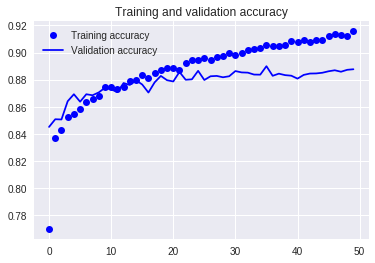

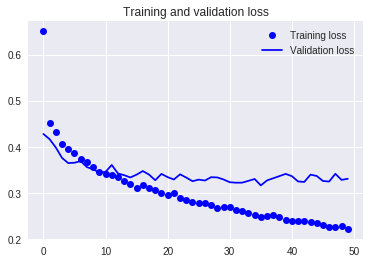

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history_mlpc.history['acc']
val_accuracy = history_mlpc.history['val_acc']
loss = history_mlpc.history['loss']
val_loss = history_mlpc.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Instantiate CNN model and train**

In [18]:
cnn = cnn(model_input)
history_cnn=compile_and_train(cnn, num_epochs=50)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 16s 343us/step - loss: 0.6640 - acc: 0.7519 - val_loss: 0.3814 - val_acc: 0.8598
Epoch 2/50
48000/48000 [==============================] - 14s 302us/step - loss: 0.4054 - acc: 0.8515 - val_loss: 0.3376 - val_acc: 0.8789
Epoch 3/50
11520/48000 [======>.......................] - ETA: 10s - loss: 0.3623 - acc: 0.8664

48000/48000 [==============================] - 14s 301us/step - loss: 0.3400 - acc: 0.8750 - val_loss: 0.2810 - val_acc: 0.8955
Epoch 4/50
48000/48000 [==============================] - 15s 302us/step - loss: 0.3059 - acc: 0.8889 - val_loss: 0.2609 - val_acc: 0.9044
Epoch 5/50
32512/48000 [===================>..........] - ETA: 4s - loss: 0.2893 - acc: 0.8956

48000/48000 [==============================] - 15s 302us/step - loss: 0.2843 - acc: 0.8959 - val_loss: 0.2601 - val_acc: 0.9021
Epoch 6/50
48000/48000 [==============================] - 15s 303us/step - loss: 0.2698 - acc: 0.9003 - val_loss: 0.2310 - val_acc: 0.9123
Epoch 7/50
37376/48000 [======================>.......] - ETA: 2s - loss: 0.2481 - acc: 0.9102

48000/48000 [==============================] - 14s 302us/step - loss: 0.2472 - acc: 0.9091 - val_loss: 0.2194 - val_acc: 0.9172
Epoch 8/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.2374 - acc: 0.9124 - val_loss: 0.2130 - val_acc: 0.9195
Epoch 9/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.2245 - acc: 0.9173

48000/48000 [==============================] - 15s 303us/step - loss: 0.2265 - acc: 0.9164 - val_loss: 0.2140 - val_acc: 0.9199
Epoch 10/50
48000/48000 [==============================] - 15s 302us/step - loss: 0.2177 - acc: 0.9193 - val_loss: 0.2022 - val_acc: 0.9234
Epoch 11/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.2090 - acc: 0.9230

48000/48000 [==============================] - 14s 302us/step - loss: 0.2085 - acc: 0.9233 - val_loss: 0.1994 - val_acc: 0.9274
Epoch 12/50
48000/48000 [==============================] - 14s 302us/step - loss: 0.2005 - acc: 0.9261 - val_loss: 0.2016 - val_acc: 0.9237
Epoch 13/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.2021 - acc: 0.9261

48000/48000 [==============================] - 14s 302us/step - loss: 0.2025 - acc: 0.9260 - val_loss: 0.2044 - val_acc: 0.9270
Epoch 14/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1936 - acc: 0.9290 - val_loss: 0.1928 - val_acc: 0.9302
Epoch 15/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1841 - acc: 0.9316

48000/48000 [==============================] - 14s 301us/step - loss: 0.1847 - acc: 0.9311 - val_loss: 0.1905 - val_acc: 0.9309
Epoch 16/50
48000/48000 [==============================] - 15s 302us/step - loss: 0.1797 - acc: 0.9332 - val_loss: 0.1916 - val_acc: 0.9316
Epoch 17/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1786 - acc: 0.9332

48000/48000 [==============================] - 14s 302us/step - loss: 0.1803 - acc: 0.9333 - val_loss: 0.1834 - val_acc: 0.9315
Epoch 18/50
48000/48000 [==============================] - 14s 300us/step - loss: 0.1749 - acc: 0.9351 - val_loss: 0.1859 - val_acc: 0.9348
Epoch 19/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1699 - acc: 0.9361

48000/48000 [==============================] - 14s 302us/step - loss: 0.1684 - acc: 0.9367 - val_loss: 0.1840 - val_acc: 0.9338
Epoch 20/50
48000/48000 [==============================] - 15s 302us/step - loss: 0.1654 - acc: 0.9379 - val_loss: 0.1849 - val_acc: 0.9351
Epoch 21/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1637 - acc: 0.9379

48000/48000 [==============================] - 14s 301us/step - loss: 0.1645 - acc: 0.9377 - val_loss: 0.1877 - val_acc: 0.9338
Epoch 22/50
48000/48000 [==============================] - 15s 302us/step - loss: 0.1618 - acc: 0.9389 - val_loss: 0.1851 - val_acc: 0.9313
Epoch 23/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1596 - acc: 0.9404

48000/48000 [==============================] - 15s 302us/step - loss: 0.1587 - acc: 0.9407 - val_loss: 0.1846 - val_acc: 0.9338
Epoch 24/50
48000/48000 [==============================] - 14s 302us/step - loss: 0.1557 - acc: 0.9427 - val_loss: 0.1821 - val_acc: 0.9378
Epoch 25/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1481 - acc: 0.9453

48000/48000 [==============================] - 14s 301us/step - loss: 0.1497 - acc: 0.9449 - val_loss: 0.1882 - val_acc: 0.9340
Epoch 26/50
48000/48000 [==============================] - 14s 300us/step - loss: 0.1496 - acc: 0.9446 - val_loss: 0.1964 - val_acc: 0.9332
Epoch 27/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1454 - acc: 0.9461

48000/48000 [==============================] - 14s 301us/step - loss: 0.1460 - acc: 0.9467 - val_loss: 0.1935 - val_acc: 0.9356
Epoch 28/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1459 - acc: 0.9459 - val_loss: 0.1819 - val_acc: 0.9385
Epoch 29/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1456 - acc: 0.9454

48000/48000 [==============================] - 14s 301us/step - loss: 0.1452 - acc: 0.9457 - val_loss: 0.1885 - val_acc: 0.9371
Epoch 30/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1396 - acc: 0.9484 - val_loss: 0.1851 - val_acc: 0.9359
Epoch 31/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1378 - acc: 0.9479

48000/48000 [==============================] - 15s 302us/step - loss: 0.1399 - acc: 0.9477 - val_loss: 0.1886 - val_acc: 0.9358
Epoch 32/50
48000/48000 [==============================] - 14s 302us/step - loss: 0.1381 - acc: 0.9484 - val_loss: 0.1821 - val_acc: 0.9379
Epoch 33/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1363 - acc: 0.9491

48000/48000 [==============================] - 14s 300us/step - loss: 0.1370 - acc: 0.9490 - val_loss: 0.1886 - val_acc: 0.9352
Epoch 34/50
48000/48000 [==============================] - 14s 298us/step - loss: 0.1344 - acc: 0.9495 - val_loss: 0.1771 - val_acc: 0.9398
Epoch 35/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1321 - acc: 0.9498

48000/48000 [==============================] - 14s 301us/step - loss: 0.1330 - acc: 0.9499 - val_loss: 0.1812 - val_acc: 0.9400
Epoch 36/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1304 - acc: 0.9493 - val_loss: 0.1828 - val_acc: 0.9392
Epoch 37/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1295 - acc: 0.9509

48000/48000 [==============================] - 14s 302us/step - loss: 0.1292 - acc: 0.9513 - val_loss: 0.1838 - val_acc: 0.9387
Epoch 38/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1235 - acc: 0.9533 - val_loss: 0.1863 - val_acc: 0.9403
Epoch 39/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1248 - acc: 0.9524

48000/48000 [==============================] - 14s 300us/step - loss: 0.1245 - acc: 0.9524 - val_loss: 0.1875 - val_acc: 0.9409
Epoch 40/50
48000/48000 [==============================] - 15s 303us/step - loss: 0.1240 - acc: 0.9526 - val_loss: 0.1791 - val_acc: 0.9407
Epoch 41/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1218 - acc: 0.9546

48000/48000 [==============================] - 15s 303us/step - loss: 0.1218 - acc: 0.9546 - val_loss: 0.1807 - val_acc: 0.9415
Epoch 42/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1207 - acc: 0.9545 - val_loss: 0.1901 - val_acc: 0.9399
Epoch 43/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1188 - acc: 0.9555

48000/48000 [==============================] - 14s 302us/step - loss: 0.1193 - acc: 0.9557 - val_loss: 0.1838 - val_acc: 0.9388
Epoch 44/50
48000/48000 [==============================] - 14s 302us/step - loss: 0.1155 - acc: 0.9561 - val_loss: 0.1839 - val_acc: 0.9407
Epoch 45/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1121 - acc: 0.9579

48000/48000 [==============================] - 14s 300us/step - loss: 0.1127 - acc: 0.9581 - val_loss: 0.1848 - val_acc: 0.9430
Epoch 46/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1166 - acc: 0.9562 - val_loss: 0.1842 - val_acc: 0.9435
Epoch 47/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1114 - acc: 0.9578

48000/48000 [==============================] - 14s 300us/step - loss: 0.1125 - acc: 0.9578 - val_loss: 0.1819 - val_acc: 0.9433
Epoch 48/50
48000/48000 [==============================] - 14s 301us/step - loss: 0.1164 - acc: 0.9560 - val_loss: 0.1834 - val_acc: 0.9415
Epoch 49/50
38400/48000 [=======================>......] - ETA: 2s - loss: 0.1082 - acc: 0.9587

48000/48000 [==============================] - 14s 300us/step - loss: 0.1088 - acc: 0.9585 - val_loss: 0.1786 - val_acc: 0.9428
Epoch 50/50
48000/48000 [==============================] - 14s 300us/step - loss: 0.1120 - acc: 0.9575 - val_loss: 0.1931 - val_acc: 0.9397


# **Evaluate CNN accuracy by test data: 0.9441**

In [19]:
evaluate_accuracy(cnn)

0.9441

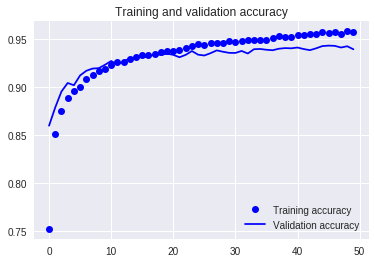

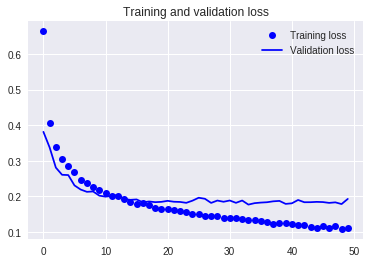

In [21]:
accuracy = history_cnn.history['acc']
val_accuracy = history_cnn.history['val_acc']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# **Create Ensemble model with MLPC and CNN**

In [0]:
models = [mlpc, cnn]

In [0]:
def ensemble(models, model_input):    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')   
    history_ensemble=compile_and_train(model, num_epochs=50)
    return model, history_ensemble

In [24]:
ensemble_model,history_ensemble = ensemble(models, model_input)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 25s 528us/step - loss: 0.1379 - acc: 0.9588 - val_loss: 0.2142 - val_acc: 0.9350
Epoch 2/50
48000/48000 [==============================] - 25s 513us/step - loss: 0.1325 - acc: 0.9605 - val_loss: 0.2180 - val_acc: 0.9345
Epoch 3/50
11520/48000 [======>.......................] - ETA: 17s - loss: 0.1322 - acc: 0.9608

48000/48000 [==============================] - 25s 514us/step - loss: 0.1325 - acc: 0.9600 - val_loss: 0.2276 - val_acc: 0.9338
Epoch 4/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1350 - acc: 0.9603 - val_loss: 0.2209 - val_acc: 0.9353
Epoch 5/50
32512/48000 [===================>..........] - ETA: 7s - loss: 0.1343 - acc: 0.9603

48000/48000 [==============================] - 25s 515us/step - loss: 0.1329 - acc: 0.9602 - val_loss: 0.2145 - val_acc: 0.9351
Epoch 6/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1311 - acc: 0.9599 - val_loss: 0.2313 - val_acc: 0.9346
Epoch 7/50
37376/48000 [======================>.......] - ETA: 5s - loss: 0.1353 - acc: 0.9610

48000/48000 [==============================] - 25s 515us/step - loss: 0.1359 - acc: 0.9605 - val_loss: 0.2225 - val_acc: 0.9357
Epoch 8/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1309 - acc: 0.9601 - val_loss: 0.2249 - val_acc: 0.9365
Epoch 9/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1284 - acc: 0.9617

48000/48000 [==============================] - 25s 516us/step - loss: 0.1280 - acc: 0.9617 - val_loss: 0.2478 - val_acc: 0.9301
Epoch 10/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1296 - acc: 0.9621 - val_loss: 0.2321 - val_acc: 0.9313
Epoch 11/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1276 - acc: 0.9639

48000/48000 [==============================] - 25s 515us/step - loss: 0.1287 - acc: 0.9634 - val_loss: 0.2340 - val_acc: 0.9360
Epoch 12/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1255 - acc: 0.9629 - val_loss: 0.2316 - val_acc: 0.9372
Epoch 13/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1304 - acc: 0.9610

48000/48000 [==============================] - 25s 515us/step - loss: 0.1303 - acc: 0.9614 - val_loss: 0.2274 - val_acc: 0.9365
Epoch 14/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1263 - acc: 0.9615 - val_loss: 0.2484 - val_acc: 0.9346
Epoch 15/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1260 - acc: 0.9626

48000/48000 [==============================] - 25s 515us/step - loss: 0.1266 - acc: 0.9625 - val_loss: 0.2341 - val_acc: 0.9351
Epoch 16/50
48000/48000 [==============================] - 25s 514us/step - loss: 0.1252 - acc: 0.9629 - val_loss: 0.2285 - val_acc: 0.9340
Epoch 17/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1222 - acc: 0.9630

48000/48000 [==============================] - 25s 515us/step - loss: 0.1250 - acc: 0.9623 - val_loss: 0.2369 - val_acc: 0.9345
Epoch 18/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1251 - acc: 0.9635 - val_loss: 0.2318 - val_acc: 0.9353
Epoch 19/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1241 - acc: 0.9628

48000/48000 [==============================] - 25s 517us/step - loss: 0.1256 - acc: 0.9623 - val_loss: 0.2321 - val_acc: 0.9378
Epoch 20/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1242 - acc: 0.9633 - val_loss: 0.2321 - val_acc: 0.9366
Epoch 21/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1254 - acc: 0.9622

48000/48000 [==============================] - 25s 514us/step - loss: 0.1263 - acc: 0.9618 - val_loss: 0.2323 - val_acc: 0.9353
Epoch 22/50
48000/48000 [==============================] - 25s 518us/step - loss: 0.1209 - acc: 0.9649 - val_loss: 0.2431 - val_acc: 0.9340
Epoch 23/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1185 - acc: 0.9645

48000/48000 [==============================] - 25s 515us/step - loss: 0.1167 - acc: 0.9655 - val_loss: 0.2350 - val_acc: 0.9352
Epoch 24/50
48000/48000 [==============================] - 25s 517us/step - loss: 0.1164 - acc: 0.9667 - val_loss: 0.2321 - val_acc: 0.9339
Epoch 25/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1120 - acc: 0.9661

48000/48000 [==============================] - 25s 515us/step - loss: 0.1133 - acc: 0.9660 - val_loss: 0.2349 - val_acc: 0.9348
Epoch 26/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1195 - acc: 0.9645 - val_loss: 0.2302 - val_acc: 0.9355
Epoch 27/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1213 - acc: 0.9633

48000/48000 [==============================] - 25s 513us/step - loss: 0.1213 - acc: 0.9634 - val_loss: 0.2361 - val_acc: 0.9376
Epoch 28/50
48000/48000 [==============================] - 25s 517us/step - loss: 0.1199 - acc: 0.9647 - val_loss: 0.2327 - val_acc: 0.9340
Epoch 29/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1144 - acc: 0.9657

48000/48000 [==============================] - 25s 515us/step - loss: 0.1145 - acc: 0.9657 - val_loss: 0.2420 - val_acc: 0.9372
Epoch 30/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1190 - acc: 0.9653 - val_loss: 0.2420 - val_acc: 0.9365
Epoch 31/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1174 - acc: 0.9654

48000/48000 [==============================] - 25s 515us/step - loss: 0.1172 - acc: 0.9651 - val_loss: 0.2327 - val_acc: 0.9378
Epoch 32/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1182 - acc: 0.9635 - val_loss: 0.2480 - val_acc: 0.9356
Epoch 33/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1192 - acc: 0.9641

48000/48000 [==============================] - 25s 515us/step - loss: 0.1191 - acc: 0.9641 - val_loss: 0.2449 - val_acc: 0.9363
Epoch 34/50
48000/48000 [==============================] - 25s 514us/step - loss: 0.1187 - acc: 0.9644 - val_loss: 0.2351 - val_acc: 0.9381
Epoch 35/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1126 - acc: 0.9652

48000/48000 [==============================] - 25s 516us/step - loss: 0.1132 - acc: 0.9654 - val_loss: 0.2501 - val_acc: 0.9372
Epoch 36/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1116 - acc: 0.9659 - val_loss: 0.2359 - val_acc: 0.9364
Epoch 37/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1113 - acc: 0.9649

48000/48000 [==============================] - 25s 515us/step - loss: 0.1119 - acc: 0.9650 - val_loss: 0.2444 - val_acc: 0.9357
Epoch 38/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1160 - acc: 0.9643 - val_loss: 0.2502 - val_acc: 0.9348
Epoch 39/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1153 - acc: 0.9665

48000/48000 [==============================] - 25s 514us/step - loss: 0.1139 - acc: 0.9664 - val_loss: 0.2602 - val_acc: 0.9338
Epoch 40/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1135 - acc: 0.9648 - val_loss: 0.2707 - val_acc: 0.9345
Epoch 41/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1116 - acc: 0.9671

48000/48000 [==============================] - 25s 516us/step - loss: 0.1112 - acc: 0.9669 - val_loss: 0.2496 - val_acc: 0.9367
Epoch 42/50
48000/48000 [==============================] - 25s 515us/step - loss: 0.1146 - acc: 0.9670 - val_loss: 0.2526 - val_acc: 0.9355
Epoch 43/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1087 - acc: 0.9665

48000/48000 [==============================] - 25s 516us/step - loss: 0.1102 - acc: 0.9657 - val_loss: 0.2656 - val_acc: 0.9345
Epoch 44/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1132 - acc: 0.9652 - val_loss: 0.2628 - val_acc: 0.9340
Epoch 45/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1128 - acc: 0.9654

48000/48000 [==============================] - 25s 513us/step - loss: 0.1131 - acc: 0.9660 - val_loss: 0.2469 - val_acc: 0.9374
Epoch 46/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1154 - acc: 0.9655 - val_loss: 0.2494 - val_acc: 0.9377
Epoch 47/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1094 - acc: 0.9673

48000/48000 [==============================] - 25s 515us/step - loss: 0.1071 - acc: 0.9677 - val_loss: 0.2677 - val_acc: 0.9388
Epoch 48/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1135 - acc: 0.9649 - val_loss: 0.2448 - val_acc: 0.9377
Epoch 49/50
38400/48000 [=======================>......] - ETA: 4s - loss: 0.1080 - acc: 0.9674

48000/48000 [==============================] - 25s 516us/step - loss: 0.1092 - acc: 0.9668 - val_loss: 0.2697 - val_acc: 0.9335
Epoch 50/50
48000/48000 [==============================] - 25s 516us/step - loss: 0.1145 - acc: 0.9640 - val_loss: 0.2427 - val_acc: 0.9375


# **Evaluate ensemble model accuracy: 0.9425**

In [25]:
evaluate_accuracy(ensemble_model)

0.9425

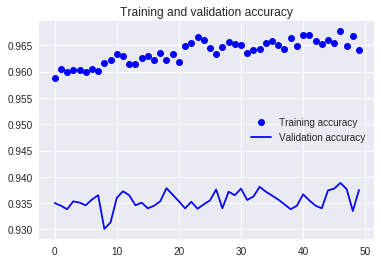

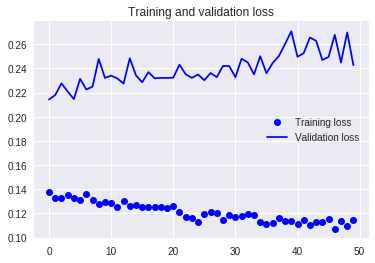

In [26]:
accuracy = history_ensemble.history['acc']
val_accuracy = history_ensemble.history['val_acc']
loss = history_ensemble.history['loss']
val_loss = history_ensemble.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()